In [1]:
import numpy as np
from imageio import imread
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
from numpy.random import normal, uniform
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


def create_X(x, y, n ):
    L = ['1']
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
            if (i == 0 and k == 0) :
                L.append('1')
            elif(i-k == 0):
                L.append('Y^' + str(k))
            elif (k == 0):
                L.append('X^' + str(i-k))
            elif (i==2 and k == 1):
                L.append('XY')
            elif(i-k == 1):
                L.append('X'+'Y^' + str(k))
            elif (k == 1):
                L.append('X^' + str(i-k)+'Y')
            else :
                L.append('X^' + str(i-k)+'Y^'+ str(k))
    return X, L

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def FrankeFunctionWithNoise(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)*len(x))
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise

def predict(beta, X):
    return X @ beta


def plotFunction(x, y, z, title):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # Plot the surface
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.suptitle(title)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    
def gradientOLS(N, x, y, theta):
    return (2.0/N)*x.T @ (x @ theta-y)

def gradientsRidge(N, lmbda, X, y, theta):
    return 2.0/N*X.T @ (X @ (theta)-y)+2*lmbda*theta

In [3]:
def SDG(X, y, n_epochs, n_batches,M,learning_rate, lmbda):
    
    theta = np.random.randn(X.shape[1])

    for epoch in range(n_epochs):
    
        np.random.shuffle(X)
        np.random.shuffle(y)
        
        for i in range(n_batches):
            
            random_index = np.random.randint(n_batches)
            xi = X[random_index:(random_index+1)]
            yi = y[random_index:(random_index+1)]
            gradient = gradientsRidge(M, lmbda, xi, yi, theta)
            theta = theta - learning_rate*gradient
  
    return theta

In [4]:
def adagradSDG(X, y, n_epochs, n_batches, M, learning_rate, lmbda):
    delta = 1e-7
    theta = np.random.randn(X.shape[1])
    r = [0.0 for _ in range(X.shape[1])]
    for epoch in range(n_epochs):
        for i in range(n_batches):
            random_index = np.random.randint(n_batches)
            xi = X[random_index:(random_index+1)]
            yi = y[(random_index):(random_index+1)]
            gradients = gradientsRidge(M, lmbda, xi, yi, theta)
            for j in range(gradients.shape[0]):
                r[j] = r[j] + gradients[j]**2.0
                alpha = eta / (delta + np.sqrt(r[j]))
                theta[j] = theta[j] - alpha * gradients[j]
    return theta

In [5]:
def adamSDG(X, y, n_epochs, n_batches, M, learning_rate, lmbda):
    
    beta_1 = 0.9
    beta_2 = 0.999
    epsi = 1e-7
    
    
    theta = np.random.randn(X.shape[1])
    m = [0.0 for _ in range(X.shape[1])]
    s = [0.0 for _ in range(X.shape[1])]
    for epoch in range(n_epochs):
        for i in range(n_batches):
            random_index = np.random.randint(n_batches)
            xi = X[random_index*M:(random_index+1)*M]
            yi = y[(random_index)*M:(random_index+1)*M]
            gradients = gradientsRidge(M, lmbda, xi, yi, theta)               
            for j in range(1, gradients.shape[0]):
                m[j] = beta_1*m[j] + (1-beta_1)*gradient[j]
                s[j] = beta_2*s[j] + (1-beta_2)*(gradient[j]**2)
                m[j] = m[j]/(1-beta_1**j)
                s[j] = s[j]/(1-beta_2**j)
                theta[j] = theta[j] -learning_rate*(m[j]/(np.sqrt(s[j])-epsi))
    return theta

In [6]:
#################    DATA     ################
################# Parameters #################

poly = 7
N = 100 #number of data

##############################################

#terrain = imread('SRTM_data_Norway_2.tif')
#terrain = terrain[:N, :N]
#Creates mesh of image pixels
#x = np.linspace(0,1, np.shape(terrain)[0])
#y = np.linspace(0,1, np.shape(terrain)[1])
#z = terrain
#x_mesh, y_mesh = np.meshgrid(x,y)


x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
x_mesh, y_mesh = np.meshgrid(x,y)
z = FrankeFunctionWithNoise(x_mesh, y_mesh)


x_y = np.empty((len(x)*len(x), 2))
x_y[:, 0] = x_mesh.ravel()
x_y[:, 1] = y_mesh.ravel()

scaler = StandardScaler()
scaler.fit(x_y)
x_y = scaler.transform(x_y)
x_y_train, x_y_test, z_train, z_test = train_test_split(x_y, z.ravel(), test_size=0.2)

X_train, coeff = create_X(x_y_train[:, 0], x_y_train[:, 1], poly )
X_test, coeff = create_X(x_y_test[:, 0], x_y_test[:, 1], poly )
X , coeff = create_X(x_y[:, 0], x_y[:, 1], poly)    

beta from linalg
[ 0.30983398 -0.0166308  -0.41566652  0.41490856  0.18441115  0.10660038
 -0.11786743 -0.28207183 -0.30907794  0.20219638 -0.2760614  -0.09021041
 -0.01501664  0.02128541 -0.10382478  0.06487906  0.17091857  0.09180827
  0.06231658  0.1165538  -0.02319023  0.04611289  0.00991629  0.01553841
  0.01289053 -0.00985245 -0.01705927  0.02196781 -0.01121094 -0.01927286
 -0.00636907 -0.0299261  -0.01999017  0.0006642  -0.01129311 -0.0024899 ]
MSE_train
[0.01073105]
MSE_test
[0.01049066]


-----------------------------


beta from linalg
[ 0.30983695 -0.0166405  -0.41565809  0.41489557  0.18440796  0.10659639
 -0.1178532  -0.2820638  -0.30906078  0.20217343 -0.2760508  -0.09020804
 -0.0150138   0.02128688 -0.10382201  0.06487177  0.17091136  0.09180019
  0.06231694  0.11654474 -0.02317572  0.04611061  0.00991586  0.01553766
  0.0128901  -0.00985278 -0.01705946  0.02196722 -0.01120972 -0.01927149
 -0.00636792 -0.02992533 -0.01998864  0.00066355 -0.01129166 -0.00249255]
MSE_train

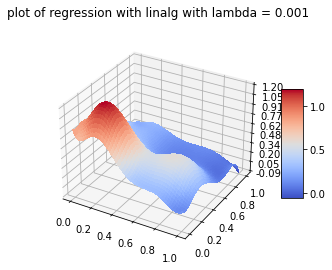

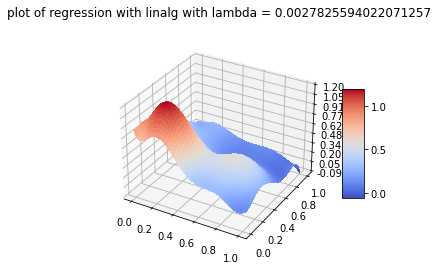

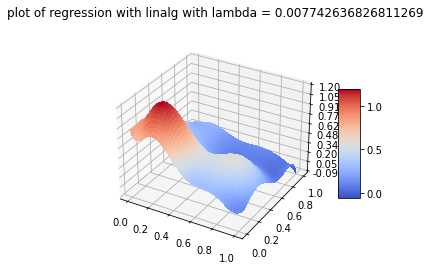

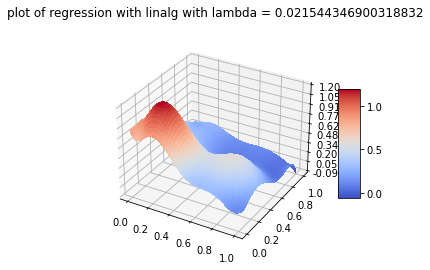

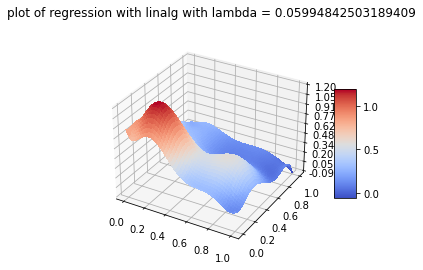

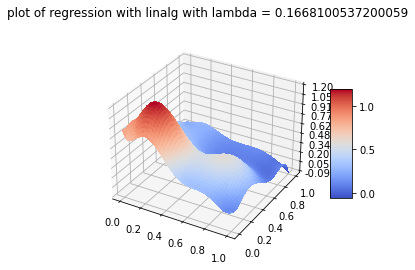

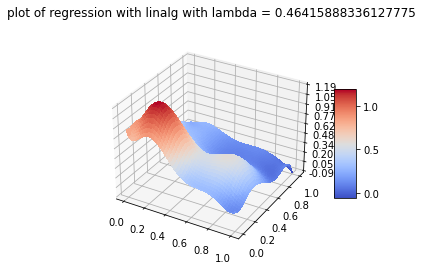

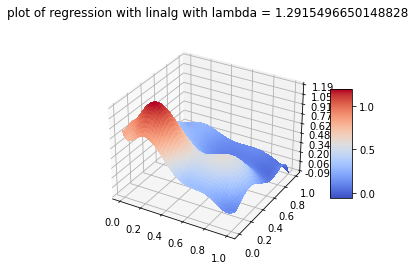

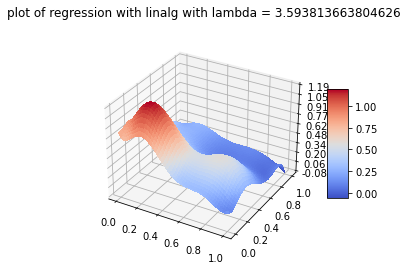

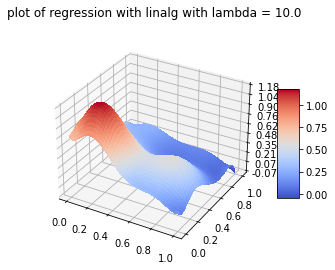

In [10]:
################### linalg Ridge #################

Lambdas = np.logspace(-3, 1, 10)

#############################################

for lmbda in Lambdas:
    beta_linreg = np.linalg.pinv(X_train.T.dot(X_train) + lmbda * np.eye(X_train.T.dot(X_train).shape[0])).dot(X_train.T).dot(z_train)
    print("beta from linalg")
    print(beta_linreg)
    ztildeLinreg = X_train @ beta_linreg
    ztestLinreg = X_test @ beta_linreg
    MSE_train_linreg = np.mean((z_train - ztildeLinreg)**2, keepdims=True )
    MSE_test_linreg = np.mean((z_test - ztestLinreg)**2, keepdims=True )
    print("MSE_train")
    print(MSE_train_linreg)
    print("MSE_test")
    print(MSE_test_linreg)
    print("\n")
    print("-----------------------------")
    print("\n")
    title = "plot of regression with linalg with lambda = " + str(lmbda)
    plotFunction(x_mesh, y_mesh, (X @ beta_linreg).reshape(len(x), len(x)), title)
plt.show()

beta from own dg
[ 0.38750355 -0.1891004  -0.85825191  0.78746688 -0.01615056 -0.60353561
  0.18880654 -0.20602542 -0.22955999  0.67406884 -0.66707468  0.43227062
  0.13665859 -0.2592915   0.46001613 -0.09662139  0.64820498  0.01973184
 -0.63838479  0.10554236 -0.01141186  0.13731064 -0.12520381  0.01586299
 -0.01293695 -0.06662961  0.0785207  -0.09523885  0.01496709 -0.15664657
  0.01179038  0.02251567 -0.01897587  0.15827815 -0.01044935 -0.04483169]
MSE_train
[0.04434594]
MSE_test
[0.04436313]


-----------------------------


beta from own dg
[ 0.50197211 -0.72394924 -0.80728351 -0.16888857 -0.12542314 -0.45336642
  0.63141872 -0.12929282  1.2650842   0.80864191  0.26161176  0.10472516
 -0.01750414  0.20464214  0.41214272 -0.22848715  0.44853458 -0.53958217
 -0.49005581 -0.78030954 -0.21952533 -0.07904176 -0.02334897  0.01781316
 -0.02687886 -0.01027493 -0.047227   -0.0980163   0.02799194 -0.10659892
  0.07174733  0.01997355  0.11152578  0.12054049  0.13970236  0.00979409]
MSE_train

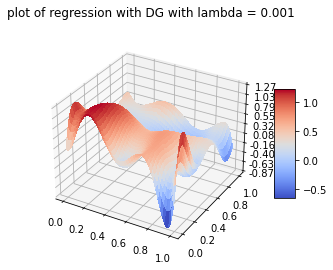

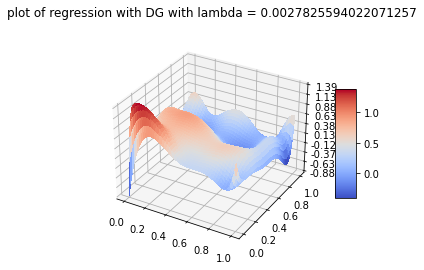

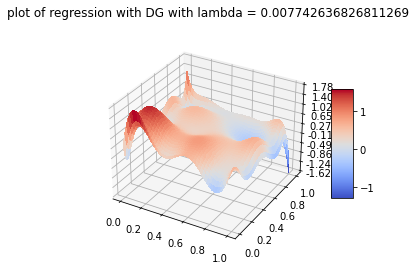

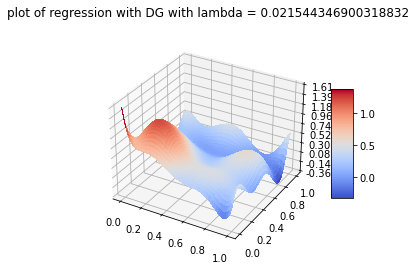

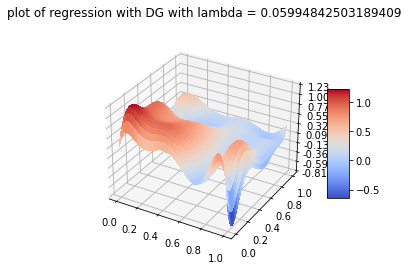

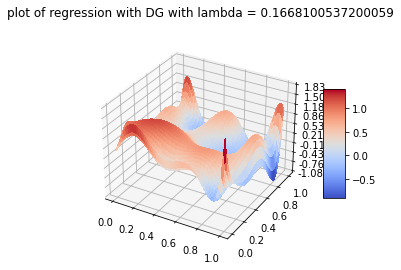

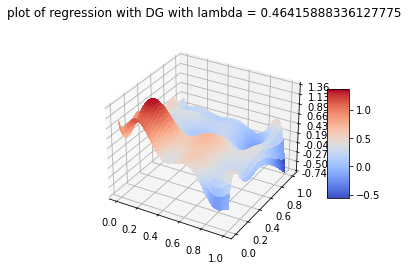

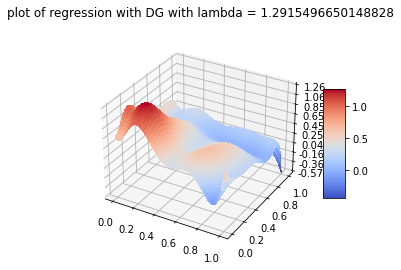

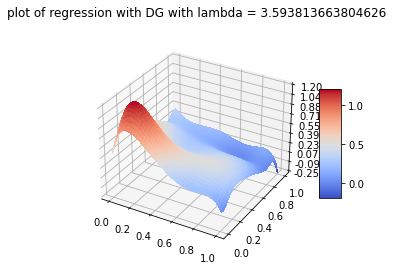

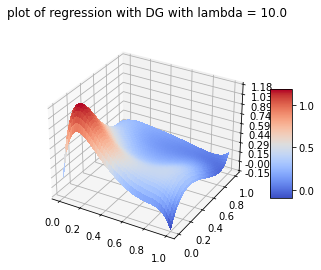

In [11]:
################### DG Ridge ##################

Niterations = 10000
Lambdas = np.logspace(-3, 1, 10)

#############################################

for lmbda in Lambdas:
    # Hessian matrix
    H = (2.0/N)* X_train.T @ X_train
    # Get the eigenvalues
    EigValues, EigVectors = np.linalg.eig(H)
    beta = np.random.randn(X_train.shape[1])
    eta = 1.0/np.max(EigValues)

    for iter in range(Niterations):
        beta = beta - eta*gradientsRidge(N, lmbda, X_train, z_train, beta)


    print("beta from own dg")
    print(beta)
    ztildeDG = predict(beta, X_train)
    ztestDG = predict(beta, X_test)
    z_pred = predict(beta, X)
    MSE_train_dg = np.mean((z_train - ztildeDG)**2, keepdims=True )
    MSE_test_dg = np.mean((z_test - ztestDG)**2, keepdims=True )
    print("MSE_train")
    print(MSE_train_dg)
    print("MSE_test")
    print(MSE_test_dg)
    print("\n")
    print("-----------------------------")
    print("\n")
    title = "plot of regression with DG with lambda = " + str(lmbda)
    plotFunction(x_mesh, y_mesh, z_pred.reshape(len(x), len(x)), title)
plt.show()

beta from own sdg
for learning_rate =  1e-05
for lambdas =  0.001
[ 0.33916026 -0.05623166 -0.89456648 -0.08323105  0.45740079 -1.95185301
  0.31969994 -0.61959495  0.3135188   1.65797678  0.63781872  0.35991736
 -0.40092215 -0.66669128  2.02344529 -0.65388614  0.08385673 -0.22810288
  0.15339819  0.36681971 -0.58598434 -0.1834775  -0.13035919 -0.04868302
  0.01911983  0.17338168  0.1599061  -0.49323057  0.21424991  0.06329463
 -0.1343663  -0.1238287   0.22912962  0.05336425 -0.21018746  0.03019601]
MSE_train
[0.44328596]
MSE_test
[0.35848464]


-----------------------------


beta from own sdg
for learning_rate =  1.6681005372000593e-05
for lambdas =  0.001
[ 0.01997795  0.55738294 -0.16344979 -1.17297455  0.19277454  0.98750197
 -0.96514167  0.57139229 -0.04093767  0.66321178  1.6317294   0.37251873
 -0.00514018 -0.81727436 -0.62228695  0.76146273 -0.504177   -0.87716148
  0.3917472   0.44771384 -0.8586981  -0.4455619  -0.09412847  0.03024953
  0.00354201 -0.07922151  0.25302654  0.1

beta from own sdg
for learning_rate =  1e-05
for lambdas =  0.007742636826811269
[ 0.23525075 -1.20573169  1.02731359  1.06652885  0.39244385  1.02319839
  0.05813989  0.16711495 -0.01144879 -0.53612191 -0.74515166 -0.66761925
 -1.52289431  0.09175242 -0.75912111  0.58047942 -0.08998252  1.15990132
 -0.65598586 -0.25763169 -0.19835592  0.19369297  0.16081265  0.06397809
  0.0333499   0.57916095 -0.0528999   0.13197392 -0.19271463 -0.03502679
 -0.11937724  0.25488623 -0.43494813  0.07404635  0.18121136  0.10222761]
MSE_train
[0.74732732]
MSE_test
[1.03787446]


-----------------------------


beta from own sdg
for learning_rate =  1.6681005372000593e-05
for lambdas =  0.007742636826811269
[ 1.97785194 -1.07848022 -0.84799281 -1.95571107 -0.03619969 -0.67420641
  0.04716431  0.26989368  0.14473411 -1.24774681  0.34157053  0.57749686
  0.88530483 -0.38082424 -0.71696638  0.47462963  0.13829706  0.07905553
 -0.62364295  0.59199092  2.15311798  0.06361984 -0.19689503 -0.13204243
  0.0331231

beta from own sdg
for learning_rate =  1e-05
for lambdas =  0.05994842503189409
[ 0.22353878 -0.80926299  0.0232836  -0.76810032 -0.2079397   0.75183781
  0.97267811 -0.13038609  0.10129357 -0.81789158  0.53375348  0.59230198
  0.28766869 -0.38791907 -0.27797824  0.52411493  0.44575187 -0.56047993
  0.09410231 -0.52281792  0.71782915 -0.06400763 -0.10011345 -0.32171412
 -0.14745512  0.19606463  0.18726774 -0.01962196 -0.27184315 -0.29410593
  0.00473255  0.46223223  0.2986598  -0.37941042  0.0985703  -0.11722896]
MSE_train
[0.74381803]
MSE_test
[0.8461286]


-----------------------------


beta from own sdg
for learning_rate =  1.6681005372000593e-05
for lambdas =  0.05994842503189409
[ 0.07439378  0.36042346 -0.0671069  -0.59303049  0.12997128  0.62485612
 -0.71496971  0.56922741 -0.25567143 -0.52960984  0.3054077  -0.02759208
  0.7176857   0.03959272 -0.35049259  0.56519651  0.14889757 -0.28618345
 -1.01536416  0.24497814  0.72774318 -0.02792239 -0.03488391 -0.16292665
  0.04882251 -

beta from own sdg
for learning_rate =  0.00021544346900318823
for lambdas =  0.1668100537200059
[ 7.37428302e+41  1.65778281e+41 -1.67525062e+41 -7.86108465e+42
  2.96881183e+41 -1.00885764e+43  8.44329347e+41  4.24706182e+42
  7.20084767e+42  4.38760422e+42 -1.00581726e+43  1.84628215e+42
 -1.49526450e+43  4.52655700e+42 -1.49702680e+43 -8.33147675e+41
  8.94916591e+41  6.41252451e+42  1.13073575e+43  9.46424447e+42
  6.41569304e+42 -1.10907579e+43  6.35032094e+42  3.34820592e+41
  8.61602318e+42  1.78346160e+43 -1.02335583e+43  7.27623684e+42
 -1.17475444e+43  4.35531564e+42 -4.59721470e+42  1.68242114e+42
 -7.30961029e+42  2.09752490e+42 -3.99020944e+42  2.31927823e+42]
MSE_train
[6.17675799e+88]
MSE_test
[7.84764286e+88]


-----------------------------


beta from own sdg
for learning_rate =  1e-05
for lambdas =  0.46415888336127775
[ 0.25201547 -0.53559526  0.58557432  0.22729696 -0.24352674  0.16811691
  0.43133094 -0.16604025 -0.06196856  0.1938488  -0.4767466   0.33190665
  0.2

beta from own sdg
for learning_rate =  7.742636826811278e-05
for lambdas =  1.2915496650148828
[ 0.09980377  0.00142519 -0.00297682  0.04433237 -0.00159734  0.04205964
  0.00165205  0.00062638  0.00150241 -0.00139835  0.03003554 -0.00141552
  0.01000178 -0.00320476  0.02688066  0.00275548  0.00083499  0.00052141
  0.00071302  0.00302056 -0.00142271  0.00116522 -0.00092697 -0.00735846
 -0.00234254 -0.01035812 -0.00732488 -0.00273447  0.006181    0.00013187
 -0.00282701 -0.00032269 -0.00070045 -0.00329729  0.00569639 -0.0028822 ]
MSE_train
[0.14317533]
MSE_test
[0.17503015]


-----------------------------


beta from own sdg
for learning_rate =  0.0001291549665014884
for lambdas =  1.2915496650148828
[ 1.00154156e-01  3.28823497e-03 -1.62203696e-03  4.22641726e-02
 -6.03660540e-04  4.18382548e-02  2.04868176e-03  1.41251687e-04
  1.66834365e-03 -5.95232577e-04  2.82320652e-02  1.35354063e-03
  7.98131596e-03  1.24092107e-03  2.75909635e-02  4.54805587e-04
  1.98287006e-04  2.59141018e-03

<ipython-input-1-d2210444a7f9>:88: RuntimeWarning: overflow encountered in matmul
  return 2.0/N*X.T @ (X @ (theta)-y)+2*lmbda*theta
<ipython-input-1-d2210444a7f9>:88: RuntimeWarning: invalid value encountered in matmul
  return 2.0/N*X.T @ (X @ (theta)-y)+2*lmbda*theta


beta from own sdg
for learning_rate =  0.00035938136638046257
for lambdas =  3.593813663804626
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
MSE_train
[nan]
MSE_test
[nan]


-----------------------------


beta from own sdg
for learning_rate =  1e-05
for lambdas =  10.0
[ 2.21396731e-02 -1.68347650e-04 -3.80926791e-04  1.27524694e-02
  3.55610920e-04  1.24091386e-02 -2.44078890e-04 -3.72395117e-04
 -5.57474849e-05 -1.49583351e-04  1.28193389e-02  4.54850280e-04
  3.56259957e-03  2.61590586e-04  1.24378968e-02 -6.75550085e-04
 -4.14109058e-04 -2.32366515e-04 -3.43706439e-04 -3.31049160e-05
  8.08706199e-05  1.28831673e-02  5.06303514e-04 -3.26652919e-03
  4.01348716e-04 -2.58733962e-03  4.97003410e-04  1.24640575e-02
 -2.07632260e-03 -1.78026503e-04 -4.46521301e-04 -6.22084633e-04
 -7.21485920e-04 -5.64302133e-04  1.36325235e-04  3.92587430e-04]
MSE_train
[0.16735486]
MSE_test
[0.1711057

<ipython-input-11-546bf7944c6f>:29: RuntimeWarning: overflow encountered in square
  MSE_train_sdg = np.mean((z_train - ztildeSDG)**2, keepdims=True )
<ipython-input-11-546bf7944c6f>:30: RuntimeWarning: overflow encountered in square
  MSE_test_sdg = np.mean((z_test - ztestSDG)**2, keepdims=True )
<ipython-input-1-d2210444a7f9>:52: RuntimeWarning: overflow encountered in square
  return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


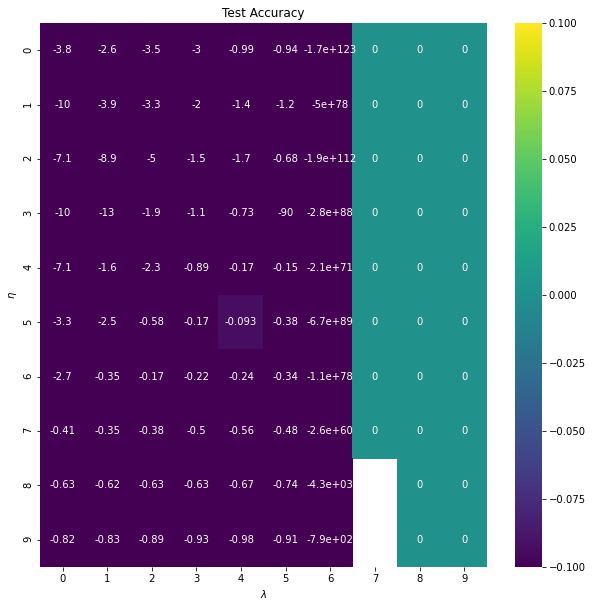

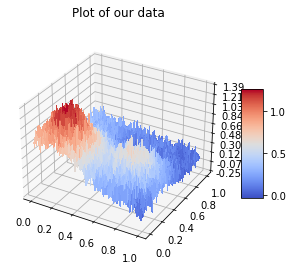

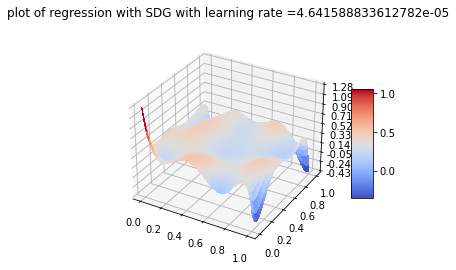

In [11]:
################### SDG RIDGE ##################
############## With Classique SDG #############
import seaborn as sns

Lambdas = np.logspace(-3, 1, 10)
nbEta = 10
Eta = np.logspace(-5, -3, nbEta)
M = 1  #size of each minibatch
n_batches = int(N/M) #number of minibatches
n_epochs = 1000 #number of epochs

#############################################
test_accuracy = np.zeros((len(Lambdas), len(Eta)))
best_eta = Eta[0]
best_mse = 1e10
best_lambda = Lambdas[0]
j = 0
for lmbda in Lambdas:
    i = 0
    MSE_train_sdg = 0
    while i < len(Eta) and MSE_train_sdg < 1e15:
        beta = SDG(X_train, z_train, n_epochs, n_batches, M = M, learning_rate = Eta[i], lmbda = lmbda)
        print("beta from own sdg")
        print("for learning_rate = ", Eta[i])
        print("for lambdas = ", lmbda)
        print(beta)
        ztildeSDG = predict(beta, X_train)
        ztestSDG = predict(beta, X_test)
        MSE_train_sdg = np.mean((z_train - ztildeSDG)**2, keepdims=True )
        MSE_test_sdg = np.mean((z_test - ztestSDG)**2, keepdims=True )
        print("MSE_train")
        print(MSE_train_sdg)
        print("MSE_test")
        print(MSE_test_sdg)
        print("\n")
        print("-----------------------------")
        print("\n")
        if MSE_test_sdg < best_mse:
            best_eta = Eta[i]
            best_mse = MSE_test_sdg
            best_lambda = lmbda
            zpred = predict(beta, X)
        test_accuracy[j][i] = R2(z_train.ravel(), ztildeSDG)
        i +=1
    j += 1

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")

plotFunction(x_mesh, y_mesh, z, "Plot of our data")
title = "plot of regression with SDG with learning rate =" + str(best_eta)
plotFunction(x_mesh, y_mesh, zpred.reshape(len(x), len(x)),title)


plt.show()

In [8]:
################### SDG RIDGE ##################
############## With Adagrad ####################
import seaborn as sns

Lambdas = np.logspace(-3, 1, 10)
nbEta = 10
Eta = np.logspace(-5, -3, nbEta)
M = 1  #size of each minibatch
n_batches = int(N/M) #number of minibatches
n_epochs = 1000 #number of epochs

#############################################
test_accuracy = np.zeros((len(Lambdas), len(Eta)))
best_eta = Eta[0]
best_mse = 1e10
best_lambda = Lambdas[0]
j = 0
for lmbda in Lambdas:
    i = 0
    MSE_train_sdg = 0
    while i < len(Eta) and MSE_train_sdg < 1e15:
        beta = adagradSDG(X_train, z_train, n_epochs, n_batches, M = M, learning_rate = Eta[i], lmbda = lmbda)
        print("beta from own sdg")
        print("for learning_rate = ", Eta[i])
        print("for lambdas = ", lmbda)
        print(beta)
        ztildeSDG = predict(beta, X_train)
        ztestSDG = predict(beta, X_test)
        MSE_train_sdg = np.mean((z_train - ztildeSDG)**2, keepdims=True )
        MSE_test_sdg = np.mean((z_test - ztestSDG)**2, keepdims=True )
        print("MSE_train")
        print(MSE_train_sdg)
        print("MSE_test")
        print(MSE_test_sdg)
        print("\n")
        print("-----------------------------")
        print("\n")
        if MSE_test_sdg < best_mse:
            best_eta = Eta[i]
            best_mse = MSE_test_sdg
            best_lambda = lmbda
            zpred = predict(beta, X)
        test_accuracy[j][i] = R2(z_train.ravel(), ztildeSDG)
        i +=1
    j += 1

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")

plotFunction(x_mesh, y_mesh, z, "Plot of our data")
title = "plot of regression with SDG with learning rate =" + str(best_eta) + " and lambda = " + str(best_lambda)
plotFunction(x_mesh, y_mesh, zpred.reshape(len(x), len(x)),title)


plt.show()

NameError: name 'AdagradSDG' is not defined